# Imports

In [52]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt

import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats import sandwich_covariance as sw
import statsmodels.api as sm
from scipy.stats import norm

# Data Exploration

In [3]:
tickers = {"S&P500": "^GSPC", "CAC40": "^FCHI"}
start_date = "2015-01-01"
end_date = "2024-12-31"

df_prices = pd.DataFrame()

for name, ticker in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date)
    df_prices[name] = df['Close']

/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_6645/316585262.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_6645/316585262.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [4]:
df_prices

,S&P500,CAC40
Date,,
2015-01-02,2058.199951,4252.290039
2015-01-05,2020.579956,4111.359863
2015-01-06,2002.609985,4083.500000
2015-01-07,2025.900024,4112.729980
2015-01-08,2062.139893,4260.189941
...,...,...
2024-12-23,5974.069824,7272.319824
2024-12-24,6040.040039,7282.689941
2024-12-26,6037.589844,NaN


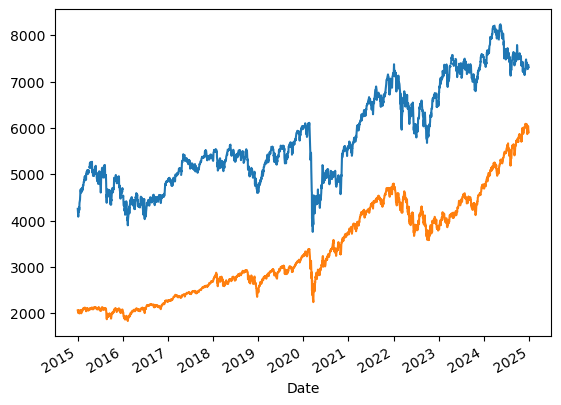

In [15]:
df_prices['CAC40'].plot()
df_prices['S&P500'].plot()
plt.show()

In [5]:
returns = df_prices.pct_change().dropna()

/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_6645/2580147993.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df_prices.pct_change().dropna()


In [7]:
returns

,S&P500,CAC40
Date,,
2015-01-05,-0.018278,-0.033142
2015-01-06,-0.008893,-0.006776
2015-01-07,0.011630,0.007158
2015-01-08,0.017888,0.035855
2015-01-09,-0.008404,-0.019041
...,...,...
2024-12-23,0.007287,-0.000297
2024-12-24,0.011043,0.001426
2024-12-26,-0.000406,0.000000


<Axes: >

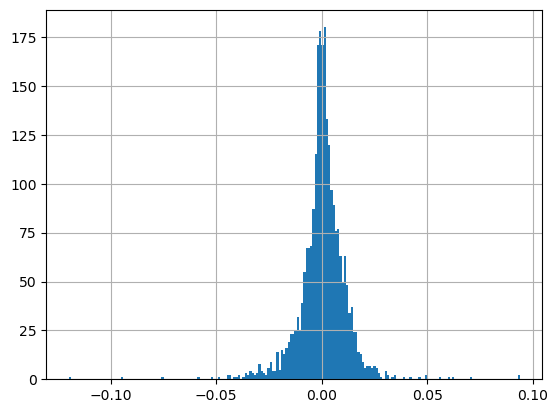

In [10]:
returns['S&P500'].hist(bins=200)

<Axes: >

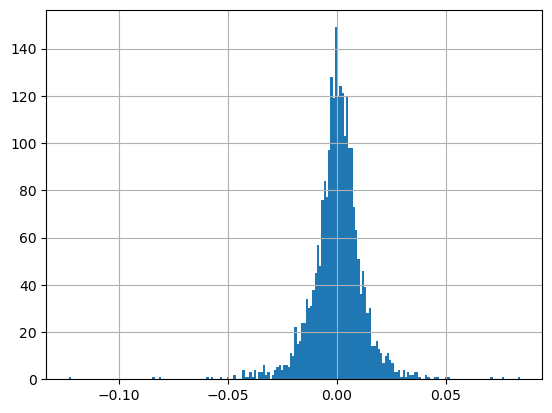

In [11]:
returns['CAC40'].hist(bins=200)

In [16]:
rolling_vol = returns.rolling(window=20).std()

<Axes: xlabel='Date'>

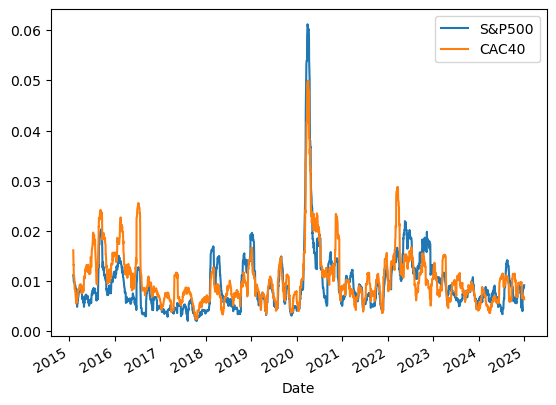

In [18]:
rolling_vol.plot()

In [20]:
rolling_corr = returns['CAC40'].rolling(window=20).corr(returns['S&P500'])

<Axes: xlabel='Date'>

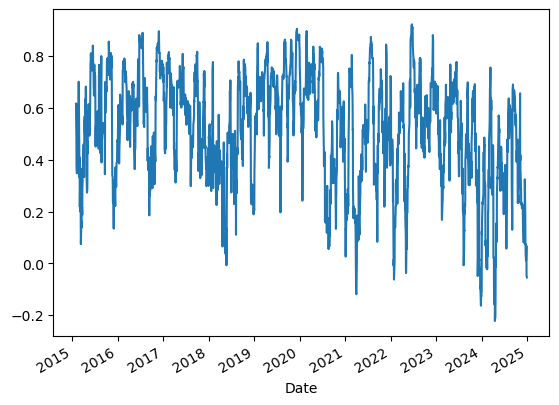

In [21]:
rolling_corr.plot()

In [ ]:
pre_covid = returns.loc['2015-01-01':'2019-12-31']
covid = returns.loc['2020-01-01':'2021-01-01']
post_covid = returns.loc['2021-01-01' :]

In [25]:
pre_covid_sq = pre_covid ** 2
post_covid_sq = post_covid ** 2
covid_sq = covid **2

<Axes: xlabel='Date'>

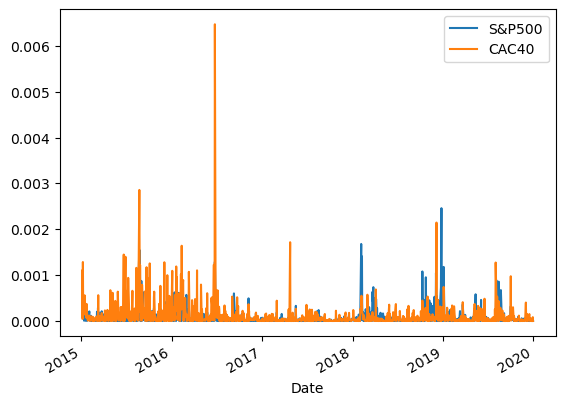

In [27]:
pre_covid_sq.plot()

<Axes: xlabel='Date'>

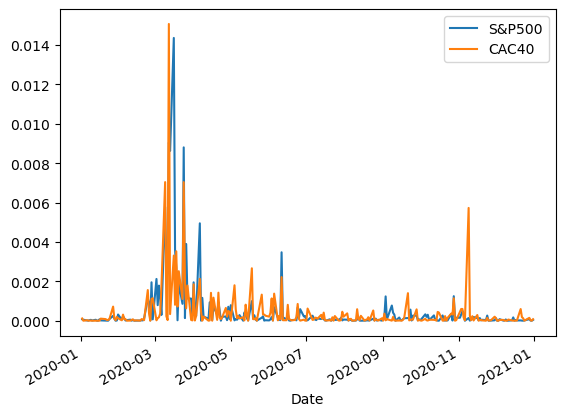

In [29]:
covid_sq.plot()

<Axes: xlabel='Date'>

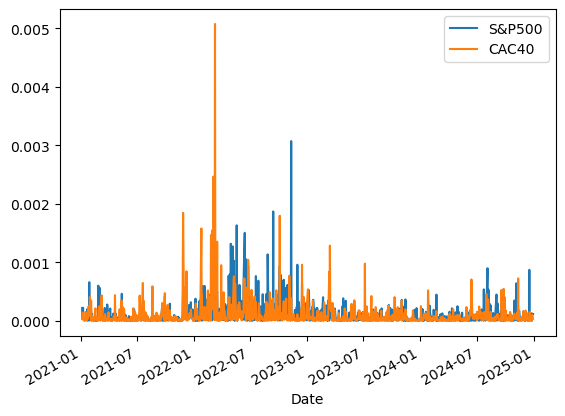

In [31]:
post_covid_sq.plot()

<Axes: xlabel='Date'>

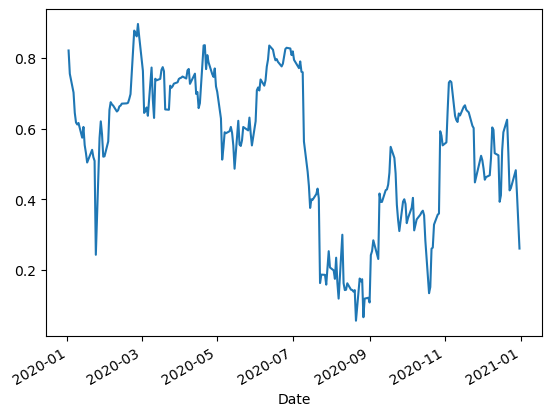

In [32]:
rolling_corr.loc['2020-01-01':'2021-01-01'].plot()

In [34]:
print(rolling_corr.loc['2020-01-01':'2021-01-01'].max())
print(rolling_corr.loc['2020-01-01':'2021-01-01'].min())

0.8966543650929834
0.055669099736181483


In [35]:
print(rolling_corr.loc['2015-01-01':'2019-12-31'].max())
print(rolling_corr.loc['2015-01-01':'2019-12-31'].min())

0.9049303340345123
-0.007026804845539065


In [36]:
print(rolling_corr.loc['2021-01-01' :].max())
print(rolling_corr.loc['2021-01-01' :].min())

0.922522131051191
-0.2218789727524371


# Statistical Analysis

In [40]:
plt.style.use("seaborn-v0_8-darkgrid")

In [ ]:
pre_covid = returns.loc["2015-01-01":"2019-12-31"]
post_covid = returns.loc["2020-01-01":"2024-12-31"]

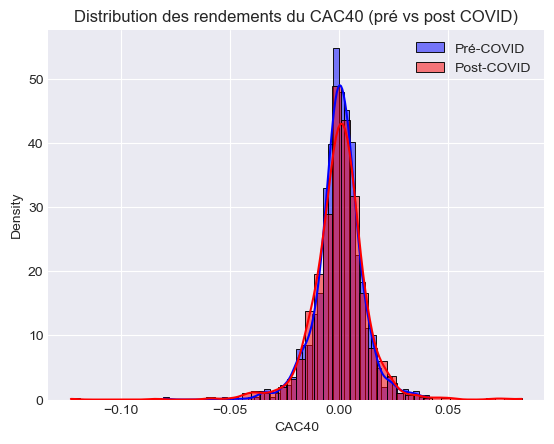

In [42]:
sns.histplot(pre_covid["CAC40"], bins=50, kde=True, color="blue", label="Pré-COVID", stat="density")
sns.histplot(post_covid["CAC40"], bins=50, kde=True, color="red", label="Post-COVID", stat="density")
plt.title("Distribution des rendements du CAC40 (pré vs post COVID)")
plt.legend()
plt.show()

In [44]:
def volatility_test(series_pre, series_post, name):
    """Compare la moyenne des carrés des rendements avant et après COVID"""
    pre_sq = series_pre**2
    post_sq = series_post**2

    # Test t de Welch sur les moyennes des carrés
    t_stat, p_val, _ = ttest_ind(pre_sq, post_sq, usevar='unequal')

    print(f"\n Test de différence de volatilité pour {name}")
    print(f"  Moyenne pré-COVID : {pre_sq.mean():.6f}")
    print(f"  Moyenne post-COVID : {post_sq.mean():.6f}")
    print(f"  t-stat = {t_stat:.3f}, p-value = {p_val:.4f}")

volatility_test(pre_covid["CAC40"], post_covid["CAC40"], "CAC40")
volatility_test(pre_covid["S&P500"], post_covid["S&P500"], "S&P500")


 Test de différence de volatilité pour CAC40
  Moyenne pré-COVID : 0.000115
  Moyenne post-COVID : 0.000168
  t-stat = -2.735, p-value = 0.0063

 Test de différence de volatilité pour S&P500
  Moyenne pré-COVID : 0.000072
  Moyenne post-COVID : 0.000181
  t-stat = -5.374, p-value = 0.0000


In [54]:
def hac_ttest(series1, series2, name, lag=10):
    """
    Test de différence de moyennes avec correction Newey-West
    (HAC) pour autocorrélation et hétéroscédasticité.
    """
    x1, x2 = np.array(series1**2), np.array(series2**2)
    diff = x1.mean() - x2.mean()
    
    # Construction des modèles pour estimer la variance HAC
    m1 = sm.OLS(x1 - x1.mean(), np.ones(len(x1))).fit()
    m2 = sm.OLS(x2 - x2.mean(), np.ones(len(x2))).fit()
    
    var1 = float(sw.cov_hac(m1, nlags=lag).item())
    var2 = float(sw.cov_hac(m2, nlags=lag).item())
    
    # Variance combinée (Welch version HAC)
    se = np.sqrt(var1/len(x1) + var2/len(x2))
    t_stat = diff / se
    
    # Approximation normale
    p_val = 2 * (1 - norm.cdf(abs(t_stat)))
    
    print(f"\n🔹 HAC-corrected volatility test for {name}")
    print(f"  Mean pre:  {x1.mean():.6f}")
    print(f"  Mean post: {x2.mean():.6f}")
    print(f"  t-stat = {t_stat:.3f}, p-value = {p_val:.4f}")

# Exemple : test CAC40 avant/après COVID avec correction
hac_ttest(pre_covid["CAC40"], post_covid["CAC40"], "CAC40 (pre vs post COVID)")
hac_ttest(pre_covid["S&P500"], post_covid["S&P500"], "SP500 (pre vs post COVID)")


🔹 HAC-corrected volatility test for CAC40 (pre vs post COVID)
  Mean pre:  0.000115
  Mean post: 0.000168
  t-stat = -56.478, p-value = 0.0000

🔹 HAC-corrected volatility test for SP500 (pre vs post COVID)
  Mean pre:  0.000072
  Mean post: 0.000181
  t-stat = -86.148, p-value = 0.0000


In [45]:
def country_vol_test(returns_period, name_period):
    """Compare la volatilité moyenne entre CAC40 et S&P500 sur une période donnée"""
    sq_cac = returns_period["CAC40"]**2
    sq_sp = returns_period["S&P500"]**2

    t_stat, p_val, _ = ttest_ind(sq_cac, sq_sp, usevar='unequal')

    print(f"\n🌍 Test de différence de volatilité CAC40 vs S&P500 ({name_period})")
    print(f"  Moyenne CAC40 : {sq_cac.mean():.6f}")
    print(f"  Moyenne S&P500 : {sq_sp.mean():.6f}")
    print(f"  t-stat = {t_stat:.3f}, p-value = {p_val:.4f}")

country_vol_test(pre_covid, "Pré-COVID (2015-2019)")
country_vol_test(post_covid, "Post-COVID (2020-2024)")


🌍 Test de différence de volatilité CAC40 vs S&P500 (Pré-COVID (2015-2019))
  Moyenne CAC40 : 0.000115
  Moyenne S&P500 : 0.000072
  t-stat = 4.516, p-value = 0.0000

🌍 Test de différence de volatilité CAC40 vs S&P500 (Post-COVID (2020-2024))
  Moyenne CAC40 : 0.000168
  Moyenne S&P500 : 0.000181
  t-stat = -0.473, p-value = 0.6361


In [55]:
def hac_country_vol_test(series1, series2, name_period, lag=None):
    """
    Teste la différence de volatilité moyenne (variance des rendements)
    entre deux indices (CAC40 vs S&P500) avec correction HAC.
    """
    x1, x2 = np.array(series1**2), np.array(series2**2)
    diff = x1.mean() - x2.mean()

    # Lag optimal de Newey-West si non précisé
    if lag is None:
        lag = int(4 * (min(len(x1), len(x2)) / 100) ** (2/9))

    # Estimation OLS + variances HAC
    m1 = sm.OLS(x1 - x1.mean(), np.ones(len(x1))).fit()
    m2 = sm.OLS(x2 - x2.mean(), np.ones(len(x2))).fit()
    var1 = float(sw.cov_hac(m1, nlags=lag))
    var2 = float(sw.cov_hac(m2, nlags=lag))

    # Variance combinée (Welch version HAC)
    se = np.sqrt(var1 / len(x1) + var2 / len(x2))
    t_stat = diff / se

    # p-value bilatérale
    p_val = 2 * (1 - norm.cdf(abs(t_stat)))

    print(f"\n🌍 HAC-corrected test CAC40 vs S&P500 ({name_period})")
    print(f"  Lag used : {lag}")
    print(f"  Mean CAC40 : {x1.mean():.6f}")
    print(f"  Mean S&P500 : {x2.mean():.6f}")
    print(f"  t-stat = {t_stat:.3f}, p-value = {p_val:.4f}")

# === Run tests ===
hac_country_vol_test(pre_covid["CAC40"], pre_covid["S&P500"], "Pré-COVID (2015–2019)")
hac_country_vol_test(post_covid["CAC40"], post_covid["S&P500"], "Post-COVID (2020–2024)")


🌍 HAC-corrected test CAC40 vs S&P500 (Pré-COVID (2015–2019))
  Lag used : 7
  Mean CAC40 : 0.000115
  Mean S&P500 : 0.000072
  t-stat = 110.786, p-value = 0.0000

🌍 HAC-corrected test CAC40 vs S&P500 (Post-COVID (2020–2024))
  Lag used : 7
  Mean CAC40 : 0.000168
  Mean S&P500 : 0.000181
  t-stat = -9.239, p-value = 0.0000


/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_6645/1003943494.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var1 = float(sw.cov_hac(m1, nlags=lag))
/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_6645/1003943494.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var2 = float(sw.cov_hac(m2, nlags=lag))


In [47]:
for name in ["CAC40", "S&P500"]:
    lb = acorr_ljungbox(returns[name]**2, lags=[10], return_df=True)
    print(f"\nAutocorrélation des carrés des rendements ({name}) :")
    display(lb)


Autocorrélation des carrés des rendements (CAC40) :


,lb_stat,lb_pvalue
10,1037.877253,1.292483e-216



Autocorrélation des carrés des rendements (S&P500) :


,lb_stat,lb_pvalue
10,3451.539168,0.0


In [49]:
covid_period = returns.loc["2020-03-01":"2020-12-31"]
print(f"\n📊 Corrélation CAC40/S&P500 en 2020 : {covid_period['CAC40'].corr(covid_period['S&P500']):.3f}")


📊 Corrélation CAC40/S&P500 en 2020 : 0.659
